In [9]:
import os
import boto3
import tarfile

In [10]:
def download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Create an S3 client
    s3_client = boto3.client('s3')

    # Download the tar.gz file from S3 to a local file
    local_tar_gz_file_path = os.path.join(destination_folder, os.path.basename(object_key))
    print(os.path.basename(object_key))
    s3_client.download_file(bucket_name, object_key, local_tar_gz_file_path)

    # Extract the contents of the tar.gz file
    with tarfile.open(local_tar_gz_file_path, 'r:gz') as tar:
        tar.extractall(destination_folder)

    # Remove the downloaded tar.gz file if needed
    os.remove(local_tar_gz_file_path)

In [11]:
!pip install safetensors
!pip install transformers --upgrade
!pip install diffusers
!pip uninstall accelerate -y
!pip install accelerate>=0.20.3


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Found existing installation: accelerate 0.21.0
Uninstalling accelerate-0.21.0:
  Successfully uninstalled accelerate-0.21.0

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [12]:
"""
This script is for LoRA weights converting. It is NOT elegant, just working for temporary usage.

(1) Train in diffusers, the LoRA is saved in .bin format. You can convert it to .safetensors for stable-diffusion-webui. Note that diffusers only support adding LoRA to UNet.

(2) Download from other platforms such as civitai, the LoRA is saved in .safetensors. You can convert it to .bin then and load in unet directly using diffusers API.

All is about weight mapping. Below are weight namings of .bin and .safetensors for a specific layer.

# model layer
# Linear(in_features=320, out_features=320, bias=False)
pipeline.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1.to_q

- .bin
'down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.up.weight' # torch.Size([320, rank])
'down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.down.weight' # torch.Size([rank, 320])

- .safetensors
'lora_unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q.lora_up.weight' # torch.Size([320, rank])
'lora_unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q.lora_down.weight' # torch.Size([rank, 320])
"""

import torch
from safetensors.torch import load_file, save_file
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler


LORA_PREFIX_UNET = 'lora_unet'


def convert_name_to_bin(name):
    
    # down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q.lora_up
    new_name = name.replace(LORA_PREFIX_UNET+'_', '')
    new_name = new_name.replace('.weight', '')
    
    # ['down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q', 'lora.up']
    parts = new_name.split('.')
    
    #parts[0] = parts[0].replace('_0', '')
    if 'out' in parts[0]:
        parts[0] = "_".join(parts[0].split('_')[:-1])
    parts[1] = parts[1].replace('_', '.')
    
    # ['down', 'blocks', '0', 'attentions', '0', 'transformer', 'blocks', '0', 'attn1', 'to', 'q']
    # ['mid', 'block', 'attentions', '0', 'transformer', 'blocks', '0', 'attn2', 'to', 'out']
    sub_parts = parts[0].split('_')

    # down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q_
    new_sub_parts = ""
    for i in range(len(sub_parts)):
        if sub_parts[i] in ['block', 'blocks', 'attentions'] or sub_parts[i].isnumeric() or 'attn' in sub_parts[i]:
            if 'attn' in sub_parts[i]:
                new_sub_parts += sub_parts[i] + ".processor."
            else:
                new_sub_parts += sub_parts[i] + "."
        else:
            new_sub_parts += sub_parts[i] + "_"
    
    # down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.up
    new_sub_parts += parts[1]
    
    new_name =  new_sub_parts + '.weight'
    
    return new_name


def safetensors_to_bin(safetensor_path, bin_path):
    
    bin_state_dict = {}
    safetensors_state_dict = load_file(safetensor_path)
        
    for key_safetensors in safetensors_state_dict:
        # these if are required  by current diffusers' API
        # remove these may have negative effect as not all LoRAs are used
        if 'text' in key_safetensors:
            continue
        if 'unet' not in key_safetensors:
            continue
        if 'transformer_blocks' not in key_safetensors:
            continue
        if 'ff_net' in key_safetensors or 'alpha' in key_safetensors:
            continue
        key_bin = convert_name_to_bin(key_safetensors)
        bin_state_dict[key_bin] = safetensors_state_dict[key_safetensors]
    
    torch.save(bin_state_dict, bin_path)

    
def convert_name_to_safetensors(name):
    
    # ['down_blocks', '0', 'attentions', '0', 'transformer_blocks', '0', 'attn1', 'processor', 'to_q_lora', 'up', 'weight']
    parts = name.split('.')
    
    # ['down_blocks', '_0', 'attentions', '_0', 'transformer_blocks', '_0', 'attn1', 'processor', 'to_q_lora', 'up', 'weight']
    for i in range(len(parts)):
        if parts[i].isdigit():
            parts[i] = '_' + parts[i]
        if "to" in parts[i] and "lora" in parts[i]:
            parts[i] = parts[i].replace('_lora', '.lora')
        
    new_parts = []
    for i in range(len(parts)):
        if i == 0:
            new_parts.append(LORA_PREFIX_UNET + '_' + parts[i])
        elif i == len(parts) - 2:
            new_parts.append(parts[i] + '_to_' + parts[i+1])
            new_parts[-1] = new_parts[-1].replace('_to_weight', '')
        elif i == len(parts) - 1:
            new_parts[-1] += '.' + parts[i]
        elif parts[i] != 'processor':
            new_parts.append(parts[i])
    new_name = '_'.join(new_parts)
    new_name = new_name.replace('__', '_')
    new_name = new_name.replace('_to_out.', '_to_out_0.')
    return new_name


def bin_to_safetensors(bin_path, safetensor_path):
    
    bin_state_dict = torch.load(bin_path)
    safetensors_state_dict = {}
    
    for key_bin in bin_state_dict:
        key_safetensors = convert_name_to_safetensors(key_bin)
        safetensors_state_dict[key_safetensors] = bin_state_dict[key_bin]
    
    save_file(safetensors_state_dict, safetensor_path)
   
    
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float16)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# Multi

In [12]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-9xo8zrlbgm2j-Lora-TrainModel-knDevfkeeA/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_multi'  # Replace with the desired destination folder path
out_name = "/multi.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

model.tar.gz


In [13]:
bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

# Single

In [15]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-pggertibdojo-Lora-TrainModel-Z7O308CIpk/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_single'  # Replace with the desired destination folder path
out_name = "/single.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

model.tar.gz


In [16]:
bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

# Multi-Cricut

In [13]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-ti4wsniphbgr-Lora-TrainModel-pHtV8h8JUt/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_multi_cricut'  # Replace with the desired destination folder path
out_name = "/multi_cricut.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Signle-Cricut

In [14]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-zv5z79ab2mj9-Lora-TrainModel-UYiFMhq1DM/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_single_cricut'  # Replace with the desired destination folder path
out_name = "/single_cricut.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Simple-Cricut

In [15]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-mhx5mef3o8zy-Lora-TrainModel-dcpYv42Tsd/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_simple'  # Replace with the desired destination folder path
out_name = "/simple.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Sticker-Cricut

In [16]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-lx9hqf5ul263-Lora-TrainModel-wg3JvdF0CM/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_sticker'  # Replace with the desired destination folder path
out_name = "/sticker.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Draw-Cricut

In [17]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-85zqa35qga7m-Lora-TrainModel-mFhkwzr9Rk/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_draw'  # Replace with the desired destination folder path
out_name = "/draw.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Cartoon-Cricut

In [18]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-7hk7x07a5fdf-Lora-TrainModel-QZ61KnrDHC/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_cartoon'  # Replace with the desired destination folder path
out_name = "/cartoon.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


# Silhouette-Cricut

In [19]:
bucket_name = 'sagemaker-image-generation-data'
sub_folder = "lora_outputs/pipelines-km1tfdfujfwm-Lora-TrainModel-nNEADFYibI/output/"
object_key = sub_folder + 'model.tar.gz'  # Replace with the actual subfolder path and object key
destination_folder = 'lora_model_silhouette'  # Replace with the desired destination folder path
out_name = "/silhouette_cricut.st"
download_and_extract_tar_gz_file(bucket_name, object_key, destination_folder)

bin_path = destination_folder + '/pytorch_lora_weights_010000.bin'
st_path = destination_folder + out_name
bin_to_safetensors(bin_path, st_path)

model.tar.gz


In [69]:
import boto3

def upload_file_to_s3(local_file_path, bucket_name, subfolder_name, s3_destination_filename=None):
    """
    Uploads a local file to an S3 bucket subfolder.

    Parameters:
    local_file_path (str): The path to the local file.
    bucket_name (str): The name of the S3 bucket.
    subfolder_name (str): The name of the subfolder within the bucket.
    s3_destination_filename (str): (Optional) The filename to be used in S3. If not provided, the original filename will be used.

    Returns:
    bool: True if the upload was successful, False otherwise.
    """
    try:
        # Create an S3 client
        s3_client = boto3.client('s3')

        # Construct the S3 destination path
        if s3_destination_filename is None:
            s3_destination_filename = local_file_path.split('/')[-1]  # Use the original filename if not provided
        s3_destination_path = f"{subfolder_name}/{s3_destination_filename}"

        # Upload the file to S3
        s3_client.upload_file(local_file_path, bucket_name, s3_destination_path)

        return True
    except Exception as e:
        print(f"Error uploading file to S3: {e}")
        return False

In [70]:
local_file_path_multi = "lora_model_multi/multi.st"
local_file_path_single = "lora_model_single/single.st"
local_file_path_multi_cricut = "lora_model_multi_cricut/multi_cricut.st"
local_file_path_single_cricut = "lora_model_single_cricut/single_cricut.st"
local_file_path_simple = "lora_model_simple/simple.st"
local_file_path_draw = "lora_model_draw/draw.st"
local_file_path_cartoon = "lora_model_cartoon/cartoon.st"
local_file_path_sticker = "lora_model_sticker/sticker.st"
local_file_path_silhouette = "lora_model_silhouette/silhouette.st"
bucket_name = 'sagemaker-image-generation-data'
subfolder_name = "lora_outputs/safetensors"
s3_destination_filename_multi = 'multi.st'
s3_destination_filename_single = 'single.st'
s3_destination_filename_multi_cricut = 'multi_cricut.st'
s3_destination_filename_single_cricut = 'single_cricut.st'
s3_destination_filename_simple = 'simple.st'
s3_destination_filename_draw = 'draw.st'
s3_destination_filename_sticker = 'sticker.st'
s3_destination_filename_silhouette = 'silhouette.st'
s3_destination_filename_cartoon = 'cartoon.st'

upload_file_to_s3(local_file_path_multi, bucket_name, subfolder_name, s3_destination_filename_multi)
upload_file_to_s3(local_file_path_single, bucket_name, subfolder_name, s3_destination_filename_single)
upload_file_to_s3(local_file_path_multi_cricut, bucket_name, subfolder_name, s3_destination_filename_multi_cricut)
upload_file_to_s3(local_file_path_single_cricut, bucket_name, subfolder_name, s3_destination_filename_single_cricut)
upload_file_to_s3(local_file_path_simple, bucket_name, subfolder_name, s3_destination_filename_simple)
upload_file_to_s3(local_file_path_draw, bucket_name, subfolder_name, s3_destination_filename_draw)
upload_file_to_s3(local_file_path_cartoon, bucket_name, subfolder_name, s3_destination_filename_cartoon)
upload_file_to_s3(local_file_path_sticker, bucket_name, subfolder_name, s3_destination_filename_sticker)
upload_file_to_s3(local_file_path_silhouette, bucket_name, subfolder_name, s3_destination_filename_silhouette)

True

# Demonstrate Result

In [5]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
import uuid
from safetensors.torch import load_file


def load_lora_weights(pipeline, checkpoint_path):
    # load base model
    pipeline.to("cuda")
    LORA_PREFIX_UNET = "lora_unet"
    LORA_PREFIX_TEXT_ENCODER = "lora_te"
    alpha = 0.75
    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path, device="cuda")
    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        # as we have set the alpha beforehand, so just skip
        if ".alpha" in key or key in visited:
            continue

        if "text" in key:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        pair_keys = []
        if "lora_down" in key:
            pair_keys.append(key.replace("lora_down", "lora_up"))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace("lora_up", "lora_down"))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list
        for item in pair_keys:
            visited.append(item)

    return pipeline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install xformers==0.0.16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 18.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyre-extensions
    Found existing installation: pyre-extensions 0.0.29
    Uninstalling pyre-extensions-0.0.29:
      Successfully uninstalled pyre-extensions-0.0.29
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.20
    Uninstalling xformers-0.0.20:
      Successfully uninstalled xformers-0.0.20

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [33]:
def inference(mode, st_path, prompt_list):
    main_pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                            use_safetensors=True,
                                                            torch_dtype=torch.float16)
    main_pipeline = load_lora_weights(main_pipeline, st_path)
    main_pipeline = main_pipeline.to("cuda")

    main_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(main_pipeline.scheduler.config)
    main_pipeline.enable_xformers_memory_efficient_attention()    
    
    for prompt in prompt_list:
        image = main_pipeline(num_inference_steps=20,
                              guidance_scale=10,
                              width=512,
                              height=512,
                              prompt=prompt).images[0]
        image.save("result/" + mode + "_" + prompt + ".png")

In [44]:
!pip install matplotlib Pillow

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def display_images(image_files, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5))

    # If there's only one row but multiple columns
    if rows == 1 and cols > 1:
        axs = axs.ravel()  # Flattens the array
    # If there are multiple rows and columns
    elif rows > 1 and cols > 1:
        axs = axs.flatten()  # Flattens the array
    # If there's only one image to display
    elif rows == 1 and cols == 1:
        axs = np.array([axs])

    for i, file in enumerate(image_files):
        img = Image.open(file)
        axs[i].imshow(img)
        axs[i].set_title(image_files[i].split("_")[1].split(".")[0])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## 1. Multi

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  7.00it/s]


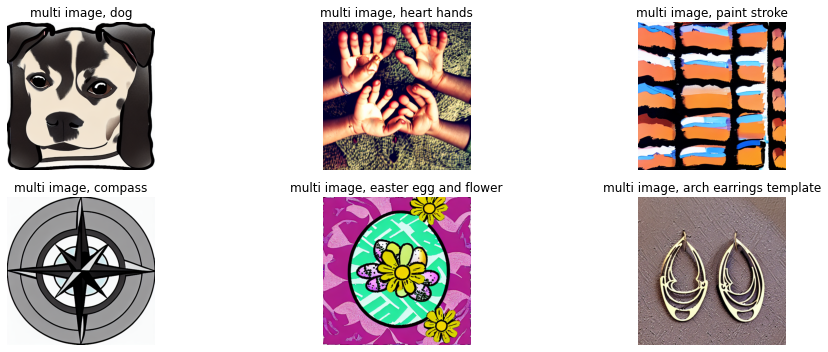

In [45]:
prompt1 = "multi image, dog"
prompt2 = "multi image, heart hands"
prompt3 = "multi image, paint stroke"
prompt4 = "multi image, compass"
prompt5 = "multi image, easter egg and flower"
prompt6 = "multi image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("multi", "lora_model_multi/multi.st", prompt_list)

mode = "multi"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

In [38]:
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
print(image_files)

['result/multi_multi image, dog.png', 'result/multi_multi image, heart hands.png', 'result/multi_multi image, paint stroke.png', 'result/multi_multi image, compass.png', 'result/multi_multi image, easter egg and flower.png', 'result/multi_multi image, arch earrings template.png']


# 2. Single

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


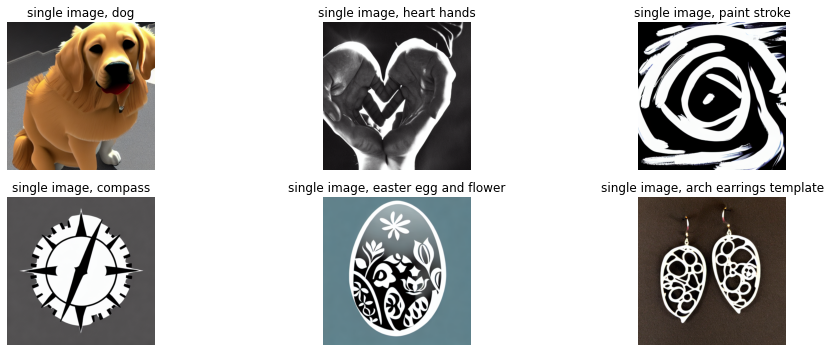

In [46]:
prompt1 = "single image, dog"
prompt2 = "single image, heart hands"
prompt3 = "single image, paint stroke"
prompt4 = "single image, compass"
prompt5 = "single image, easter egg and flower"
prompt6 = "single image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("single", "lora_model_single/single.st", prompt_list)

mode = "single"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 3. Multi-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


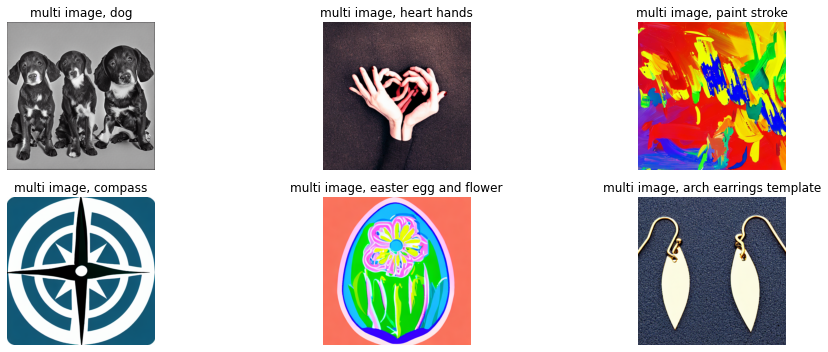

In [53]:
prompt1 = "multi image, dog"
prompt2 = "multi image, heart hands"
prompt3 = "multi image, paint stroke"
prompt4 = "multi image, compass"
prompt5 = "multi image, easter egg and flower"
prompt6 = "multi image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("multi-cricut", "lora_model_multi_cricut/multi_cricut.st", prompt_list)

mode = "multi-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 4. Single-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


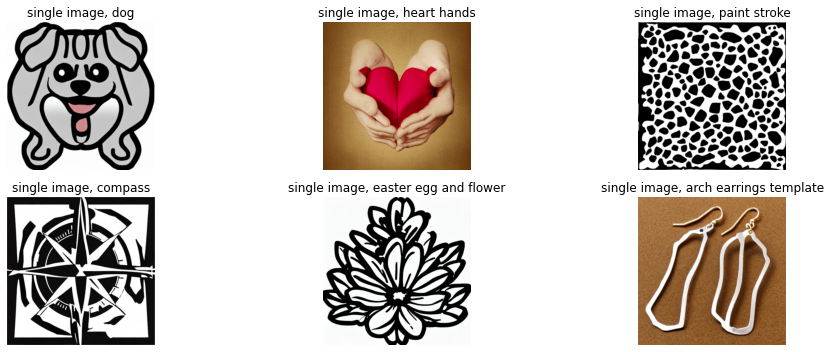

In [56]:
prompt1 = "single image, dog"
prompt2 = "single image, heart hands"
prompt3 = "single image, paint stroke"
prompt4 = "single image, compass"
prompt5 = "single image, easter egg and flower"
prompt6 = "single image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("single-cricut", "lora_model_single_cricut/single_cricut.st", prompt_list)

mode = "single-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 5. Simple-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


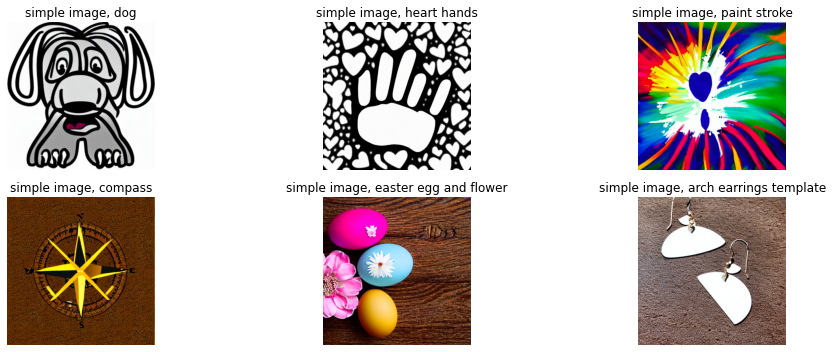

In [59]:
prompt1 = "simple image, dog"
prompt2 = "simple image, heart hands"
prompt3 = "simple image, paint stroke"
prompt4 = "simple image, compass"
prompt5 = "simple image, easter egg and flower"
prompt6 = "simple image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("simple-cricut", "lora_model_simple/simple.st", prompt_list)

mode = "simple-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 6. Sticker-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


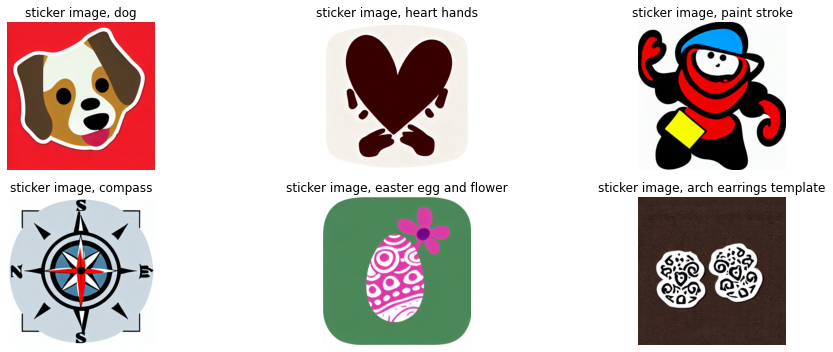

In [60]:
prompt1 = "sticker image, dog"
prompt2 = "sticker image, heart hands"
prompt3 = "sticker image, paint stroke"
prompt4 = "sticker image, compass"
prompt5 = "sticker image, easter egg and flower"
prompt6 = "sticker image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("sticker-cricut", "lora_model_sticker/sticker.st", prompt_list)

mode = "sticker-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 7. Draw-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.94it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


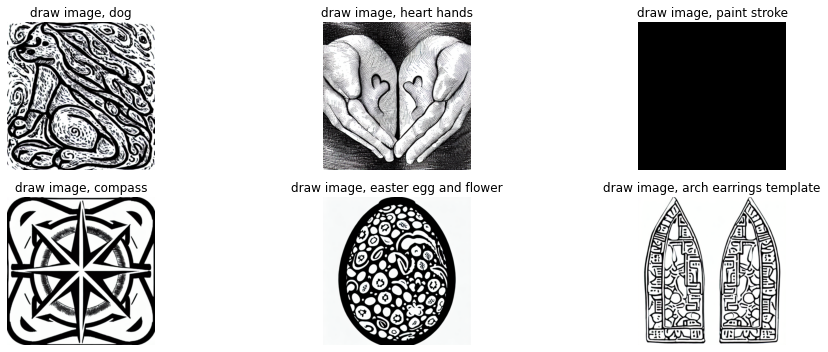

In [62]:
prompt1 = "draw image, dog"
prompt2 = "draw image, heart hands"
prompt3 = "draw image, paint stroke"
prompt4 = "draw image, compass"
prompt5 = "draw image, easter egg and flower"
prompt6 = "draw image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("draw-cricut", "lora_model_draw/draw.st", prompt_list)

mode = "draw-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 8. Cartoon-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


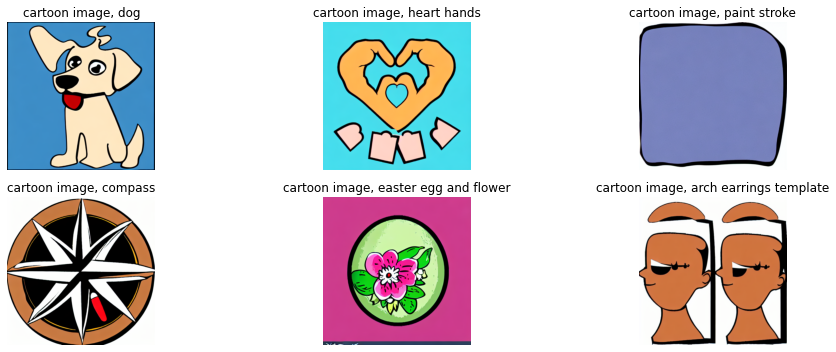

In [64]:
prompt1 = "cartoon image, dog"
prompt2 = "cartoon image, heart hands"
prompt3 = "cartoon image, paint stroke"
prompt4 = "cartoon image, compass"
prompt5 = "cartoon image, easter egg and flower"
prompt6 = "cartoon image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("cartoon-cricut", "lora_model_cartoon/cartoon.st", prompt_list)

mode = "cartoon-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)

## 9. Silhouette-Cricut

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


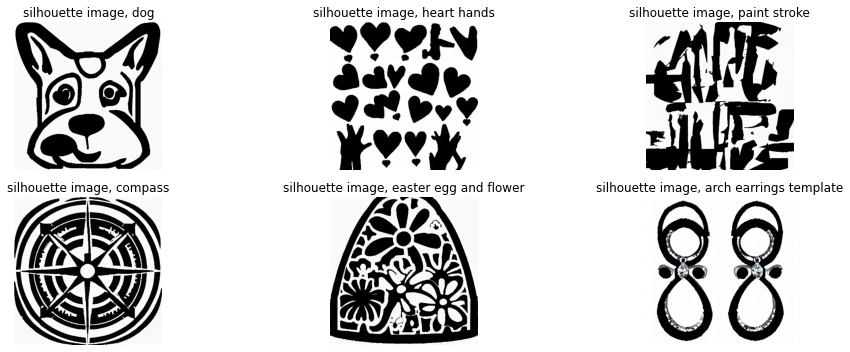

In [66]:
prompt1 = "silhouette image, dog"
prompt2 = "silhouette image, heart hands"
prompt3 = "silhouette image, paint stroke"
prompt4 = "silhouette image, compass"
prompt5 = "silhouette image, easter egg and flower"
prompt6 = "silhouette image, arch earrings template"

prompt_list = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]
inference("silhouette-cricut", "lora_model_silhouette/silhouette.st", prompt_list)

mode = "silhouette-cricut"
image_files = ["result/" + mode + "_" + prompt + ".png" for prompt in prompt_list]
display_images(image_files, 2, 3)